In [1]:
import time
import joblib
import tensorflow as tf
from termcolor import cprint
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F


Import model architecture and checkpoints from scripts:

In [18]:
from lstm_train_test import *
from train_utils import *

In [3]:
device = 'cuda'
encoder = EncoderRNN(input_size=2)
decoder = DecoderRNN(output_size=5)
encoder = nn.DataParallel(encoder)
decoder = nn.DataParallel(decoder)
encoder.to(device)
decoder.to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters())
decoder_optimizer = torch.optim.Adam(decoder.parameters())

model_utils = ModelUtils()

#change this to actual path
model_path = '../checkpoints/lstmfixed/LSTM_rollout30.pth.tar'
epoch, rollout_len, _ = model_utils.load_checkpoint(
            model_path, encoder, decoder, encoder_optimizer,
            decoder_optimizer)

=> loading checkpoint '../checkpoints/lstmfixed/LSTM_rollout30.pth.tar'
=> loaded checkpoint ../checkpoints/lstmfixed/LSTM_rollout30.pth.tar (epoch: 556, loss: 3.4132704734802246)


validation model:

In [24]:
from datasets.argoverse_lane_loader import read_pkl_data

dataset_path = '../../argoverse_data'
val_path = os.path.join(dataset_path, 'val') #, 'lane_data'
val_dataset = read_pkl_data(val_path, batch_size=1, shuffle=False, repeat=False)

## Visualization

sorry this part is adapted legacy code so it's a bit messy...

the key idea is it predicts \[x, y, sigma_x, sigma_y, rho\] and you can make the x, y coordinates and the covariance matrix for the Gaussian with this function:

In [6]:
def make_sigma(pred):
    x_sigma = pred[:,2]
    y_sigma = pred[:,3]
    rho = pred[:,4]
    off_diag = rho * x_sigma * y_sigma
    C = np.array([[np.power(x_sigma,2), off_diag], [off_diag, np.power(y_sigma,2)]])
    return pred[:,:2], C
    

The following code are for making predictions and making visualizations like this:

(run all the code before running the command below, you will need to install the argoverse api as indicated in the repo.)

/home/ss/.local/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


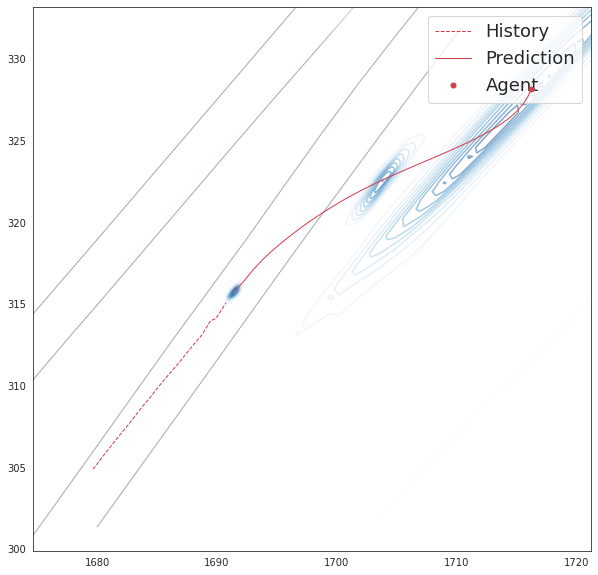

In [30]:
for valdata in val_dataset:
    lstm_res = lstm_pred(valdata, encoder, decoder)
    visualize_trajectory(lstm_res, gt=False, show=True)
    break

helper functions for pre-preocessing:

In [5]:
from shapely.geometry import Point, Polygon, LineString, LinearRing
from shapely.affinity import affine_transform, rotate

def trans(df):
    
    normalized_traj = []
    x_coord_seq = df[:,:,0]
    y_coord_seq = df[:,:,1]

    # Normalize each trajectory
    for i in range(x_coord_seq.shape[0]):
        xy_seq = np.stack((x_coord_seq[i], y_coord_seq[i]), axis=-1)

        start = xy_seq[0]
        # First apply translation
        m = [1, 0, 0, 1, -start[0], -start[1]]
        ls = LineString(xy_seq)


        # Now apply rotation, taking care of edge cases
        ls_offset = affine_transform(ls, m)
       
        # Normalized trajectory
        norm_xy = np.array(ls_offset) #ls_rotate)

        # Update the containers
        normalized_traj.append(norm_xy)
        
    normalize_traj_arr = np.stack(normalized_traj)
    return normalize_traj_arr

def untrans(pred, df):
    
    normalized_traj = []
    x_coord_seq = df[:,:,0]
    y_coord_seq = df[:,:,1]
    
    x_pred_seq = pred[:,:,0]
    y_pred_seq = pred[:,:,1]

    # Normalize each trajectory
    for i in range(x_coord_seq.shape[0]):
        xy_seq = np.stack((x_coord_seq[i], y_coord_seq[i]), axis=-1)
        
        pred_seq = np.stack((x_pred_seq[i], y_pred_seq[i]), axis=-1)
        
        start = xy_seq[0]
        # First apply translation
        m = [1, 0, 0, 1, start[0], start[1]]
        ls = LineString(pred_seq)


        # Now apply rotation, taking care of edge cases
        ls_offset = affine_transform(ls, m)
       
        # Normalized trajectory
        norm_xy = np.array(ls_offset) #ls_rotate)

        # Update the containers
        normalized_traj.append(norm_xy)
        
    normalize_traj_arr = np.stack(normalized_traj)
    normalize_traj_arr = np.concatenate([normalize_traj_arr,pred[:,:,2:]],axis=2 )
    return normalize_traj_arr

Making predictions

In [8]:
def lstm_pred(sample, encoder, decoder):
    data = process_batch(sample, 'cpu')

    agent_id = data['agent_id']
    city = data['city']
    scene = data['scene_idx'][0]
    
    input_length = 19
    output_length = 30
    track_id = sample['track_id'][0]
    agent_idx = np.where(track_id==agent_id)[0][0]
    intraj = sample['p_in'][0][agent_idx,:,:]
    intraj = np.expand_dims(intraj, axis=0)
    normalized = trans(intraj) 

    # ------------------getting ground truth from data for visualization--------------

    zeros = np.zeros((1, 2, 2))

    prediction0 = construct_df(intraj[:,0,:], zeros, 
                               agent_id, agent_id, 
                               city,scene)
    for i in range(1,19):
        prediction0 = prediction0.append(construct_df(intraj[:,i,:], zeros, 
                               agent_id, agent_id, 
                               city,scene))
    _input = torch.tensor(normalized, device=device, dtype=torch.float32)

    
    # ------------------ prediction --------------

    # Encoder
    batch_size = _input.shape[0]
    input_length = _input.shape[1]
    input_shape = _input.shape[2]

    # Initialize encoder hidden state
    encoder_hidden = model_utils.init_hidden(
        batch_size,
        encoder.module.hidden_size)
    
    with torch.no_grad():
        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)

        # Initialize decoder input with last coordinate in encoder
        decoder_input = torch.cat([encoder_input[:, :2], torch.zeros(batch_size,3,device=encoder_input.device)], dim=1)
        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        output_shape = (_input.shape[0], 30, 5) #batch size, timesteps, [x, y, x_sigma, y_sigma, rho]
        decoder_outputs = torch.zeros(output_shape).to(device)

        for di in range(output_length):
            decoder_output, decoder_hidden = decoder(decoder_input,
                                                     decoder_hidden)

            output = Gaussian2d(decoder_output)
            decoder_outputs[:, di, :] = output
    
    decoder_outputs = decoder_outputs.cpu().numpy()
    decoder_outputs = untrans(decoder_outputs, intraj)
    
    for i in range(output_length):
        
        xy, sigma = make_sigma(decoder_outputs[:,i,:])

        prediction0 = prediction0.append(construct_df(xy, sigma.reshape((1,2,2)),
                                           agent_id, agent_id, 
                                           city,scene))

    return prediction0


Helper functions for making visualizations:

In [27]:
import pandas as pd
import seaborn as sns
from collections import defaultdict
from typing import Dict, Optional
from datasets import helper
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [9]:
def construct_df(pos, sig, track_id, agent_id, city,scene_idx):
    obj_type = np.array(['OTHERS'] * len(pos))
    track_id = track_id.squeeze()#.tolist()
    agent_id = agent_id.squeeze() if isinstance(agent_id,  (np.ndarray, np.generic) ) else agent_id
    city = city.squeeze() if isinstance(city,  (np.ndarray, np.generic) ) else city
    sigs = [[s] for s in sig]

    obj_type[track_id == agent_id] = 'AGENT'
    df = pd.DataFrame(data = {'scene_idx': scene_idx,
                               'TRACK_ID': track_id, 
                              'X': pos[:,0], 
                              'Y': pos[:,1], 
                              'sigma': sigs,
                              'OBJECT_TYPE': obj_type, 
                              'CITY_NAME': city})
    return df

In [29]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
_ZORDER = {"AGENT": 15, "AV": 10, "OTHERS": 5}

def visualize_trajectory(
    df: pd.DataFrame, lane_centerlines = None, show: bool = True, smoothen: bool = False, 
    gt = True, lane_centerlines_df =None
) -> None:
    sns.set_style("white")

    # Seq data
    # time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    if lane_centerlines_df is not None:
        lane_centerlines = helper.get_lanes(lane_centerlines_df, city_name) if lane_centerlines is None else lane_centerlines
        x_min = min(lane_centerlines_df["X"])-10
        x_max = max(lane_centerlines_df["X"])+20
        y_min = min(lane_centerlines_df["Y"])-10
        y_max = max(lane_centerlines_df["Y"])+10
    else:
        lane_centerlines = helper.get_lanes(df, city_name) if lane_centerlines is None else lane_centerlines
        x_min = min(df["X"])-5
        x_max = max(df["X"])+5
        y_min = min(df["Y"])-5
        y_max = max(df["Y"])+5
    

    plt.figure(0, figsize=(10, 10))

    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "-", color="darkgrey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")


    color_dict = {"AGENT": "#d33e4c", "OTHERS": "deepskyblue", "AV": "deepskyblue"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    otherlegend = True
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]
        isagent = (object_type =='AGENT')
        
        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values
        sigmas = [np.array(x[0]) for x in group_data['sigma'].values]

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x[:19],
            cor_y[:19],
            "--",
            color=color_dict[object_type],
            label="History" if ( isagent or otherlegend) else '_nolegend_',
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
        

        plt.plot(
            cor_x[19:],
            cor_y[19:],
            "-",
            color=color_dict[object_type],
            label=("Ground Truth" if gt else "Prediction")if ( isagent or otherlegend) else '_nolegend_' ,
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )
    

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 5
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 5
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 5
        
        lab = ''
        if isagent:
            lab='Agent'
        elif otherlegend:
            lab='Others'
        else:
            lab = '_nolegend_'
        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=lab,
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )
        
        if not isagent:
            otherlegend=False
        
        if isagent and not gt:
            for i in [19,34,48]: #range(len(pred)):
                samples = np.random.multivariate_normal([cor_x[i],cor_y[i]], sigmas[i], size=600)
                sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5) 


        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")
    #plt.axis("off")
    
    plt.legend(loc='upper right',prop={'size': 18})
    if show:
        plt.show()